# MiniVGG #

In [1]:
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.InteractiveSession(config=config)

In [2]:
import visiontools
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

## Untrained ##

In [3]:
SIZE = [192, 192]

model = keras.Sequential([
    layers.Conv2D(filters=64,
                  kernel_size=3,
                  activation="relu",
                  padding='same',
                  name="block1_conv1", input_shape=[*SIZE, 3]),
    layers.MaxPool2D(name="block1_pool"),
    layers.Conv2D(filters=128,
                  kernel_size=3,
                  activation="relu",
                  padding='same',
                  name="block2_conv1"),
    layers.MaxPool2D(name="block2_pool"),
    layers.Conv2D(filters=256,
                  kernel_size=3,
                  activation="relu",
                  padding='same',
                  name="block3_conv1"),
    layers.Conv2D(filters=256,
                  kernel_size=3,
                  activation="relu",
                  padding='same',
                  name="block3_conv2"),
    layers.MaxPool2D(name="block3_pool"),
    layers.Conv2D(filters=512,
                  kernel_size=3,
                  activation="relu",
                  padding='same',
                  name="block4_conv1"),
    layers.Conv2D(filters=512,
                  kernel_size=3,
                  activation="relu",
                  padding='same',
                  name="block4_conv2"),
    layers.Conv2D(filters=512,
                  kernel_size=3,
                  activation="relu",
                  padding='same',
                  name="block4_conv3"),
    layers.MaxPool2D(name="block4_pool"),
    layers.Flatten(),
    layers.Dense(8, activation="relu"),
    layers.Dense(1, activation="sigmoid")
], name='minivgg')
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)
model.save('minivgg-untrained')

## Pretrained ##

In [4]:
# Load training and validation sets
DATA_DIR = '/home/jovyan/work/kaggle/datasets'
(ds_train_, ds_valid_), ds_info = tfds.load('stanford_cars/simple',
                                          split=['train', 'test'],
                                          shuffle_files=True,
                                          with_info=True,
                                          data_dir=DATA_DIR)

BATCH_SIZE = 16
AUTO = tf.data.experimental.AUTOTUNE
SIZE = [192, 192]
preprocess = visiontools.make_preprocessor(size=SIZE)

ds_train = (ds_train_
            .map(preprocess, AUTO)
            .cache()
            .repeat()
            .shuffle(ds_info.splits['train'].num_examples)
            .batch(BATCH_SIZE)
            .prefetch(AUTO))

ds_valid = (ds_valid_
            .map(preprocess, AUTO)
            .cache()
            .shuffle(ds_info.splits['test'].num_examples)
            .batch(BATCH_SIZE)
            .prefetch(AUTO))

Epoch 1/100
319/319 [==============================] - 51s 161ms/step - loss: 0.6534 - binary_accuracy: 0.6132 - val_loss: 0.5887 - val_binary_accuracy: 0.6987 - lr: 1.0000e-04
Epoch 2/100
319/319 [==============================] - 43s 135ms/step - loss: 0.5571 - binary_accuracy: 0.7163 - val_loss: 0.5112 - val_binary_accuracy: 0.7545 - lr: 1.0000e-04
Epoch 3/100
319/319 [==============================] - 43s 135ms/step - loss: 0.4577 - binary_accuracy: 0.7864 - val_loss: 0.4280 - val_binary_accuracy: 0.8109 - lr: 1.0000e-04
Epoch 4/100
319/319 [==============================] - 43s 135ms/step - loss: 0.3918 - binary_accuracy: 0.8282 - val_loss: 0.3697 - val_binary_accuracy: 0.8339 - lr: 1.0000e-04
Epoch 5/100
319/319 [==============================] - 43s 136ms/step - loss: 0.3044 - binary_accuracy: 0.8770 - val_loss: 0.3175 - val_binary_accuracy: 0.8602 - lr: 1.0000e-04
Epoch 6/100
319/319 [==============================] - 44s 136ms/step - loss: 0.2389 - binary_accuracy: 0.9011 - va

KeyError: 'Passing list-likes to .loc or [] with any missing labels is no longer supported, see https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike'

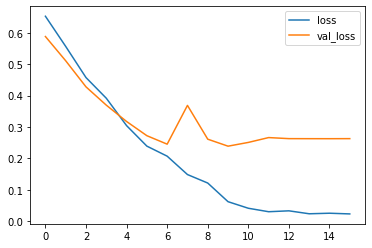

In [5]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True)
lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(patience=2)

EPOCHS = 100
STEPS_PER_EPOCH = ds_info.splits['train'].num_examples // BATCH_SIZE

history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[early_stopping, lr_schedule],
)

history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

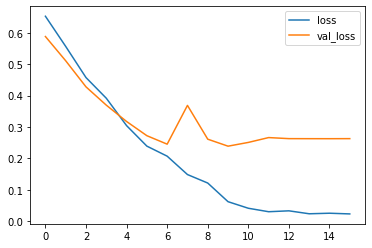

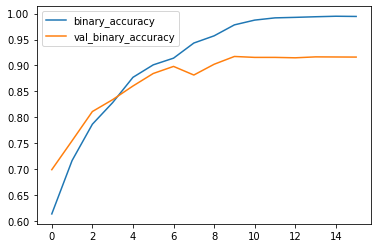

In [6]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

In [7]:
model.save('minivgg-trained')